<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Make-data" data-toc-modified-id="Make-data-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Make data</a></span><ul class="toc-item"><li><span><a href="#Make-network" data-toc-modified-id="Make-network-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Make network</a></span><ul class="toc-item"><li><span><a href="#Make-cases" data-toc-modified-id="Make-cases-1.1.1"><span class="toc-item-num">1.1.1&nbsp;&nbsp;</span>Make cases</a></span></li></ul></li></ul></li><li><span><a href="#Compute-gradient" data-toc-modified-id="Compute-gradient-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Compute gradient</a></span><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Tasks" data-toc-modified-id="Tasks-2.0.1"><span class="toc-item-num">2.0.1&nbsp;&nbsp;</span>Tasks</a></span></li></ul></li></ul></li></ul></div>

In [4]:
using Pkg; Pkg.activate()

using Distributions, Random
using LightGraphs
using Convex, ECOS
using Plots

using Revise
using CarbonNetworks

ECOS_QUIET = () -> ECOS.Optimizer(verbose=false)

#3 (generic function with 1 method)

In [5]:
using LinearAlgebra

# Make data

## Make network

In [6]:
Random.seed!(2)
n = 50

# Make graph
G = watts_strogatz(n, 4, 0.2)

# Convert to incidence matrix
A = incidence_matrix(G, oriented=true)
m = size(A, 2)

# Generate costs
f = rand(Exponential(5), n) .+ 2

# Generate generation and flow capacities
gmax = rand(Gamma(5.0, 5.0), n)
pmax = rand(Gamma(1.0, 1.0), m)

B = I;

### Make cases

In [7]:
Random.seed!(3)

num_cases = 500

cases = []
for _ in 1:num_cases
    d = rand(Uniform(0.5, 1.0), n) .* gmax
    
    opf = PowerManagementProblem(f, d, pmax, gmax, A)
    solve!(opf, ECOS_QUIET)
    
    push!(cases, (d=d, g=evaluate(opf.g)))
end

train_cases = cases[1:400]
test_cases = cases[401:end];

# Compute gradient

We want to solve 

$$\text{minimize}_\theta\quad L(g^*(\theta)) + \frac{\lambda}{2} \| f \|_2^2$$
    
where $L(g) = \frac{1}{2} \| g - g_{\mathrm{true}} \|_2^2$ and $g^*(\theta)$ is the OPF mapping. This gradient of the loss is $\nabla L(g) = g - g_{\mathrm{true}}$.

### Tasks

- [ ] Speed up algorithm via warm starting
- [ ] Tune regularization parameters
- [ ] Verify that LMPs are similar to true LMPs (since that is what matters)

In [73]:
Random.seed!(4)

# Algorithm parameters
step_size = 0.05
max_iter = 130
batch_size = 5
test_batch_size = 5
λ = 0

# Initialize estimated costs
f̂ = rand(Exponential(5), n) .+ 2

train_loss_hist = []
test_loss_hist = []
grad_hist = []
acc_hist = []

@time for iter in 1:max_iter
    # Evaluate loss and gradient
    sample = rand(1:length(train_cases), batch_size)
    L, df = stochastic_loss_and_grad(f̂, B, train_cases, pmax, gmax, A, sample)
    
    push!(train_loss_hist, L)
    push!(grad_hist, norm(df))
    push!(acc_hist, abs(f̂'f) / (norm(f̂) * norm(f)))
    
    # Compute test loss
    sample = rand(1:length(test_cases), test_batch_size)
    L_test, _ = stochastic_loss_and_grad(f̂, B, train_cases, pmax, gmax, A, sample)
    push!(test_loss_hist, L_test)
    
    # Take projected gradient step
    η = step_size
    f̂ = max.(f̂ - η*(df .+ λ), 2)
end
println("Completed $(max_iter) iterations.")

 11.285315 seconds (16.20 M allocations: 10.982 GiB, 6.78% gc time)
Completed 130 iterations.


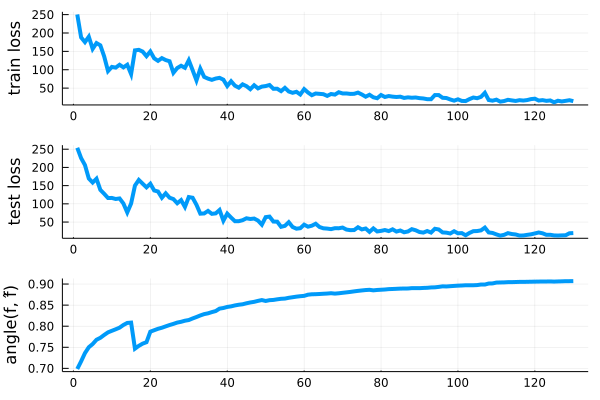

In [74]:
theme(:default, lw=4, label=nothing)

plot(
    plot(train_loss_hist, ylabel="train loss"),
    plot(test_loss_hist, ylabel="test loss"),
    plot(acc_hist, ylabel="angle(f, f̂)"),
    layout=(3, 1)
)

sum(f̂) = 509.01340879511747
sum(f) = 293.2319736492847


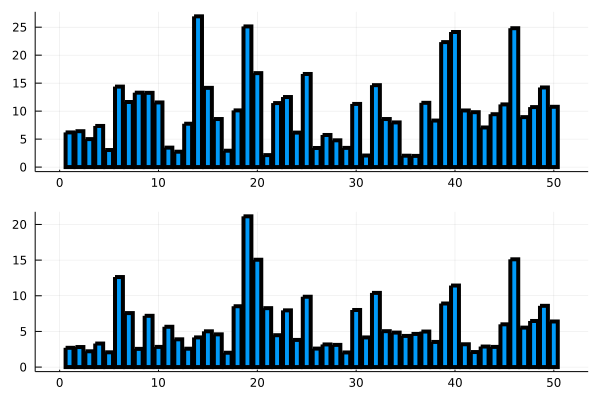

In [75]:
@show sum(f̂)
@show sum(f)

merit_order = sortperm(f)
est_order = sortperm(f̂)

plot(bar(f̂), bar(f), layout=(2, 1))